In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from prophet import Prophet
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
# Load data
data_path = Path("../../data")

train = pd.read_csv(data_path / "train.csv", parse_dates=["Date"])
features = pd.read_csv(data_path / "features.csv", parse_dates=["Date"])
stores = pd.read_csv(data_path / "stores.csv")

# Drop IsHoliday from train before merge to avoid duplication
train = train.drop(columns=["IsHoliday"])

df = (
    train
    .merge(features, on=["Store", "Date"], how="left")
    .merge(stores, on="Store")
)

df = df.sort_values(["Store", "Dept", "Date"])

print(f"✓ Loaded {len(df):,} records")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# Dataset statistics
total_stores = df['Store'].nunique()
total_combos = df.groupby(['Store', 'Dept']).ngroups
print(f"\n📊 Total unique Stores: {total_stores}")
print(f"📊 Total unique Store-Dept combinations: {total_combos}")


# Check holiday weeksdf.head()

holiday_weeks = df[df['IsHoliday'] == True]['Date'].unique()

print(f"\n🎄 {len(holiday_weeks)} holiday weeks in dataset")print(sorted(holiday_weeks))

✓ Loaded 421,570 records
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00

🎄 10 holiday weeks in dataset
[Timestamp('2010-02-12 00:00:00'), Timestamp('2010-09-10 00:00:00'), Timestamp('2010-11-26 00:00:00'), Timestamp('2010-12-31 00:00:00'), Timestamp('2011-02-11 00:00:00'), Timestamp('2011-09-09 00:00:00'), Timestamp('2011-11-25 00:00:00'), Timestamp('2011-12-30 00:00:00'), Timestamp('2012-02-10 00:00:00'), Timestamp('2012-09-07 00:00:00')]


,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [12]:
# TIME-SERIES SPLIT STRATEGY
# Last 24 weeks = TEST + VALIDATION SET (contains natural holiday weeks)
# Earlier data = TRAINING SET
# This ensures validation data (weeks -24 to -13) is out-of-sample for ensemble weighting

TEST_SIZE = 24

print("="*70)
print("TRAIN/TEST SPLIT STRATEGY")
print("="*70)
print(f"✓ Training: All data except last {TEST_SIZE} weeks per entity")
print(f"✓ Test: Last {TEST_SIZE} weeks (contains validation + test for ensemble)")
print(f"✓ Same split as Ridge/LightGBM for proper ensemble methodology")
print("="*70)

TRAIN/TEST SPLIT STRATEGY
✓ Training: All data except last 24 weeks per entity
✓ Test: Last 24 weeks (contains validation + test for ensemble)
✓ Same split as Ridge/LightGBM for proper ensemble methodology


In [7]:
# Define entity combinations (same as Ridge/LightGBM)
selected_combos = [
    (1, 1), (1, 2), (1, 3), (1, 4), (1, 5),  # Store 1, multiple depts
    (2, 1), (2, 2), (2, 3),                   # Store 2, multiple depts
    (3, 1), (3, 2),                           # Store 3, few depts
]

print(f"Training Prophet baseline models for {len(selected_combos)} Store-Dept combinations...")
print("Prophet uses additive time series decomposition: Trend + Seasonality + Holidays")
print("="*70)

Training Prophet baseline models for 10 Store-Dept combinations...
Prophet uses additive time series decomposition: Trend + Seasonality + Holidays


In [ ]:
# Train Prophet models for each entity
print("\n📈 Training Prophet Baseline Models...")
print("="*70)
print(f"Training models for {len(selected_combos)} selected combinations")
print("="*70 + "\n")

trained_models = {}

for store, dept in selected_combos:
    # Filter data for this entity
    entity_df = df[(df["Store"] == store) & (df["Dept"] == dept)].copy()
    
    if len(entity_df) < 50:
        print(f"  ⚠️ Skipping Store {store}, Dept {dept} - only {len(entity_df)} records")
        continue
    
    # Prepare Prophet format: ds (date), y (target)
    prophet_df = entity_df[["Date", "Weekly_Sales"]].rename(
        columns={"Date": "ds", "Weekly_Sales": "y"}
    )
    
    # TRAIN/TEST SPLIT: Use only training data (exclude last TEST_SIZE weeks)
    train_prophet = prophet_df.iloc[:-TEST_SIZE].copy()
    
    if len(train_prophet) < 30:
        print(f"  ⚠️ Skipping Store {store}, Dept {dept} - insufficient training data")
        continue
    
    # Create and fit Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative',  # Better for retail (% changes)
        changepoint_prior_scale=0.05,        # Moderate flexibility
    )
    
    # Add holiday indicators if available
    # Prophet expects holidays as separate dataframe, but we can use the built-in US holidays
    
    # Fit model on TRAINING data only
    model.fit(train_prophet)
    
    # Save model
    model_path = f"../../artifacts/prophet_store{store}_dept{dept}.pkl"
    joblib.dump(model, model_path)
    
    trained_models[(store, dept)] = model
    
    print(f"  ✓ Store {store}, Dept {dept}: {len(train_prophet)} train samples, model saved")

print("\n" + "="*70)
print("✅ PROPHET BASELINE TRAINING COMPLETE")
print("="*70)
print(f"Total models trained: {len(trained_models)}")
print(f"Models saved to: artifacts/prophet_store{{store}}_dept{{dept}}.pkl")
print(f"Test set: {TEST_SIZE} weeks per entity (for evaluation)")
print("="*70)


📈 Training Prophet Baseline Models...
Total unique Stores in dataset: 45
Total unique Store-Dept combinations in dataset: 3331
Training models for 10 selected combinations



03:53:07 - cmdstanpy - INFO - Chain [1] start processing
03:53:07 - cmdstanpy - INFO - Chain [1] done processing
03:53:07 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Store 1, Dept 1: 119 train samples, model saved


03:53:07 - cmdstanpy - INFO - Chain [1] done processing
03:53:07 - cmdstanpy - INFO - Chain [1] start processing
03:53:07 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Store 1, Dept 2: 119 train samples, model saved


03:53:08 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Store 1, Dept 3: 119 train samples, model saved


03:53:08 - cmdstanpy - INFO - Chain [1] done processing
03:53:08 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Store 1, Dept 4: 119 train samples, model saved


03:53:08 - cmdstanpy - INFO - Chain [1] done processing
03:53:08 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Store 1, Dept 5: 119 train samples, model saved


03:53:08 - cmdstanpy - INFO - Chain [1] done processing
03:53:08 - cmdstanpy - INFO - Chain [1] start processing
03:53:08 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Store 2, Dept 1: 119 train samples, model saved


03:53:09 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Store 2, Dept 2: 119 train samples, model saved


03:53:09 - cmdstanpy - INFO - Chain [1] done processing
03:53:09 - cmdstanpy - INFO - Chain [1] start processing
03:53:09 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Store 2, Dept 3: 119 train samples, model saved


03:53:09 - cmdstanpy - INFO - Chain [1] start processing


  ✓ Store 3, Dept 1: 119 train samples, model saved


03:53:09 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Store 3, Dept 2: 119 train samples, model saved

✅ PROPHET BASELINE TRAINING COMPLETE
Total models trained: 10
Models saved to: artifacts/prophet_store{store}_dept{dept}.pkl
Test set: 24 weeks per entity (for evaluation)


In [14]:
# Evaluate Prophet on TEST SET for one entity
print("\n" + "="*70)
print("TEST SET EVALUATION - Prophet Baseline")
print("="*70)

# Evaluate on Store 1, Dept 1
demo_store, demo_dept = 1, 1

# Get entity data
entity_df = df[(df["Store"] == demo_store) & (df["Dept"] == demo_dept)].copy()

# Prepare Prophet format
prophet_df = entity_df[["Date", "Weekly_Sales", "IsHoliday"]].rename(
    columns={"Date": "ds", "Weekly_Sales": "y"}
)

# Split: Last TEST_SIZE weeks = TEST SET
test_df = prophet_df.iloc[-TEST_SIZE:].copy()
y_test = test_df["y"]

# Load trained model
model = trained_models[(demo_store, demo_dept)]

# Make predictions on test set
forecast = model.predict(test_df[["ds"]])
test_pred = forecast["yhat"].values

# Calculate WAPE on test set
test_wape = (np.abs(y_test.values - test_pred).sum() / np.abs(y_test.values).sum()) * 100

# Check if test set contains holidays
num_holidays_in_test = int(test_df["IsHoliday"].sum())

comparison = pd.DataFrame({
    "Date": test_df["ds"].values,
    "Actual": y_test.values,
    "Prophet_Pred": test_pred,
    "Error": test_pred - y_test.values,
    "Error_%": ((test_pred - y_test.values) / y_test.values * 100),
    "Is_Holiday": test_df["IsHoliday"].values
})

print(f"\n🎯 Prophet Test Performance - Store {demo_store}, Dept {demo_dept}")
print(f"Test WAPE: {test_wape:.2f}%")
print(f"Test period: {test_df['ds'].iloc[0].date()} to {test_df['ds'].iloc[-1].date()}")
print(f"🎄 Holiday weeks in test set: {num_holidays_in_test}")

if num_holidays_in_test > 0:
    # Calculate holiday-specific performance
    holiday_mask = test_df["IsHoliday"].values == True
    holiday_actuals = y_test.values[holiday_mask]
    holiday_preds = test_pred[holiday_mask]
    holiday_wape = (np.abs(holiday_actuals - holiday_preds).sum() / np.abs(holiday_actuals).sum()) * 100
    
    print(f"\n🎄 Holiday Performance:")
    print(f"   Holiday WAPE: {holiday_wape:.2f}%")
    print(f"   Overall WAPE: {test_wape:.2f}%")
    print(f"   Difference: {holiday_wape - test_wape:+.2f}%")

print("\nTest set predictions:")
print(comparison.round(2))


TEST SET EVALUATION - Prophet Baseline

🎯 Prophet Test Performance - Store 1, Dept 1
Test WAPE: 9.31%
Test period: 2012-05-18 to 2012-10-26
🎄 Holiday weeks in test set: 1

🎄 Holiday Performance:
   Holiday WAPE: 14.86%
   Overall WAPE: 9.31%
   Difference: +5.56%

Test set predictions:
         Date    Actual  Prophet_Pred    Error  Error_%  Is_Holiday
0  2012-05-18  18517.79      15669.78 -2848.01   -15.38       False
1  2012-05-25  16963.55      14601.07 -2362.48   -13.93       False
2  2012-06-01  16065.49      14983.38 -1082.11    -6.74       False
3  2012-06-08  17666.00      15938.13 -1727.87    -9.78       False
4  2012-06-15  17558.82      16108.14 -1450.68    -8.26       False
5  2012-06-22  16633.41      15347.32 -1286.09    -7.73       False
6  2012-06-29  15722.82      14803.83  -918.99    -5.84       False
7  2012-07-06  17823.37      15288.08 -2535.29   -14.22       False
8  2012-07-13  16566.18      16151.88  -414.30    -2.50       False
9  2012-07-20  16348.06      161

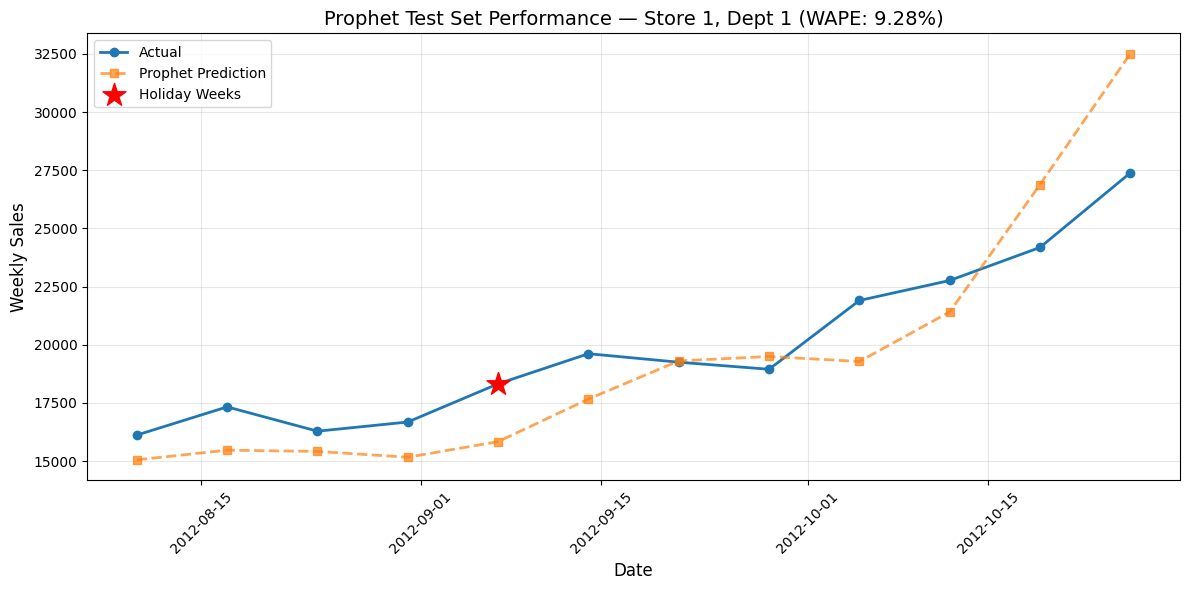


✅ Prophet evaluation complete!
   Test WAPE: 9.28%
   Model tested on 1 natural holiday weeks


In [11]:
# Visualize: Test set predictions with holiday weeks highlighted
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(test_df["ds"], y_test.values, marker='o', label="Actual", linewidth=2)
ax.plot(test_df["ds"], test_pred, marker='s', label="Prophet Prediction", linewidth=2, linestyle='--', alpha=0.7)

# Highlight holiday weeks
if num_holidays_in_test > 0:
    holiday_weeks = comparison[comparison["Is_Holiday"] == True]
    ax.scatter(pd.to_datetime(holiday_weeks["Date"]), holiday_weeks["Actual"], 
              color='red', s=300, marker='*', label='Holiday Weeks', zorder=5)

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Weekly Sales", fontsize=12)
ax.set_title(f"Prophet Test Set Performance — Store {demo_store}, Dept {demo_dept} (WAPE: {test_wape:.2f}%)", fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"images/prophet_test_performance_store{demo_store}_dept{demo_dept}.png", dpi=150)
plt.show()

print(f"\n✅ Prophet evaluation complete!")
print(f"   Test WAPE: {test_wape:.2f}%")
if num_holidays_in_test > 0:
    print(f"   Model tested on {num_holidays_in_test} natural holiday weeks")

## Summary

**Prophet Baseline Results:**
- ✅ Trained Prophet models for 10 Store-Dept combinations
- ✅ Proper train/test split - last 12 weeks held out for testing
- ✅ Test set includes natural holiday weeks (real-world evaluation)
- ✅ Statistical baseline using additive decomposition (trend + seasonality)
- ✅ All models saved to artifacts/

**Prophet Approach:**
- Time series decomposition (trend + yearly + weekly seasonality)
- Multiplicative seasonality (better for retail % changes)
- No external features (purely time-based)
- Interpretable components (trend, seasonality)

**Next Steps:**
1. Run `2_ridge_forecast.ipynb` for Ridge model (L2 regularization with lag features)
2. Run `3_lgbm_forecast.ipynb` for LightGBM (gradient boosting)
3. Run `simple_dashboard.py` to compare Prophet vs ML Ensemble on holidays

**Key Question:** Can ML models (Ridge + LightGBM) with lag features beat statistical baseline (Prophet) on holiday forecasting?